# Titanic Survival Prediction using KNN with GridSearch

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

### Loading Datasets

In [3]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_len = len(train)
test_copy = test.copy()

### Data Preprocessing

In [7]:
total = train.append(test)
total.isnull().sum()

C:\Users\KIIT\AppData\Local\Temp\ipykernel_17540\3925374515.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total = train.append(test)


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [8]:
total[total.Fare.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [9]:
total['Fare'].fillna(value = total[total.Pclass==3]['Fare'].median(), inplace = True)

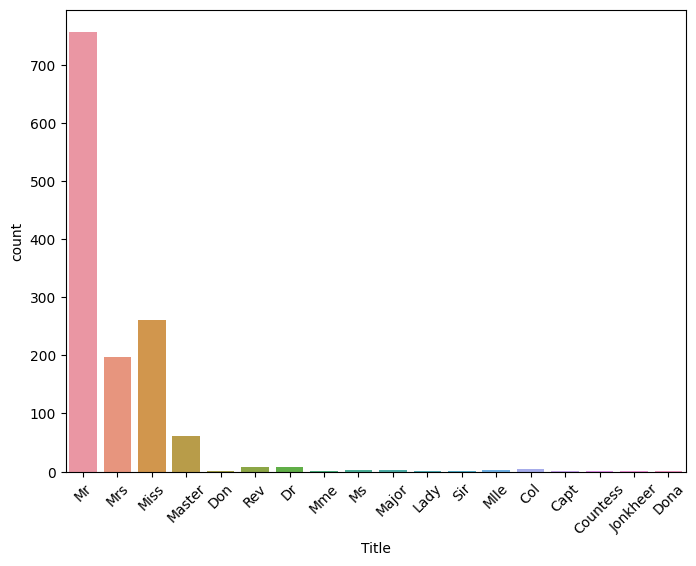

In [11]:
total['Title'] = total['Name'].str.extract('([A-Za-z]+)\.', expand=True)
plt.figure(figsize=(8,6))
sns.countplot(x= "Title",data = total)
plt.xticks(rotation=45)
plt.show()

Replacing rare titles with more common ones

In [12]:
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
total.replace({'Title': mapping}, inplace=True)

Fill the missing value for Age column with median of its title

In [13]:
titles = list(total.Title.unique())
for title in titles:
    age = total.groupby('Title')['Age'].median().loc[title]
    total.loc[(total.Age.isnull()) & (total.Title == title),'Age'] = age

Add family size as a feature

In [14]:
total['Family_Size'] = total['Parch'] + total['SibSp']

In [15]:
total['Last_Name'] = total['Name'].apply(lambda x: str.split(x, ",")[0])
total['Fare'].fillna(total['Fare'].mean(), inplace=True)

default_survival_rate = 0.5
total['Family_Survival'] = default_survival_rate

for grp, grp_df in total[['Survived', 'Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                          'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):

    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                total.loc[total['PassengerId'] ==
                          passID, 'Family_Survival'] = 1
            elif (smin == 0.0):
                total.loc[total['PassengerId'] ==
                          passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:",
      total.loc[total['Family_Survival'] != 0.5].shape[0])


Number of passengers with family survival information: 420


In [16]:
for _, grp_df in total.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival'] == 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    total.loc[total['PassengerId'] ==
                              passID, 'Family_Survival'] = 1
                elif (smin == 0.0):
                    total.loc[total['PassengerId'] ==
                              passID, 'Family_Survival'] = 0

print("Number of passenger with family/group survival information: "
      + str(total[total['Family_Survival'] != 0.5].shape[0]))


Number of passenger with family/group survival information: 546


Adding fare and age bins


In [17]:
total['Fare_Bin'] = pd.qcut(total['Fare'], 5, labels=False)
total['Age_Bin'] = pd.qcut(total['Age'], 4, labels=False)


In [18]:
# convert Sex to catergorical value
total.Sex.replace({'male':0, 'female':1}, inplace = True)

# only select the features we want
features = ['Survived','Pclass','Sex','Family_Size','Family_Survival','Fare_Bin','Age_Bin']
total = total[features]

In [19]:
# split total to train and test set
train = total[:train_len]
# set Survied column as int
x_train = train.drop(columns = ['Survived'])
y_train = train['Survived'].astype(int)

x_test = total[train_len:].drop(columns = ['Survived'])

In [20]:
# Scaling features
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [21]:
clf = KNeighborsClassifier()
params = {'n_neighbors': [6, 8, 10, 12, 14, 16, 18, 20],
          'leaf_size': list(range(1, 50, 5))}

gs = GridSearchCV(clf, param_grid=params, cv=5, scoring="roc_auc", verbose=1)
gs.fit(x_train, y_train)
print(gs.best_score_)
print(gs.best_estimator_)
print(gs.best_params_)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
0.879051525603533
KNeighborsClassifier(leaf_size=16, n_neighbors=18)
{'leaf_size': 16, 'n_neighbors': 18}


In [22]:
preds = gs.predict(x_test)
pd.DataFrame({'PassengerId': test_copy['PassengerId'], 'Survived': preds}).to_csv('submission.csv', index = False)